<a id="1"></a> <br>
## Import Libraries

In [28]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
from metrics import *

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 

<a id="2"></a> <br>
## Load Data

In [29]:
import os

os.chdir(r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research")

In [30]:
# adding attribute name to each dataframe

def add_attribute_name(df_list, df_name):
    """
    Adds an attribute name to each DataFrame in a list.

    :param df_list: List of pandas DataFrames to add attribute names to.
    :param attribute_name: Name of the attribute to add.
    :return: List of DataFrames with attribute names.
    """
    for index, df in enumerate(df_list, start=1):
        df.name = f"{df_name[index-1]}"
        
    return df_list



In [31]:

experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']


def load_data (experiments):
    # Load the data
    df_list = []
    for exp in experiments:
        df = pd.read_csv(f"data/final_cleaned/{exp}.csv", index_col = 'input_Timepoint (hr)', parse_dates=True)

        df.name = exp
        df_list.append(df)
    return df_list

# Load the data
experiment_data = load_data(experiment_names)
experiment_data = add_attribute_name(experiment_data, experiment_names)



In [32]:
# Group the loaded CSVs by experiment date (assuming the date is the first part of the experiment name before '_')
grouped_experiments = {}

for name, df in zip(experiment_names, experiment_data):
    date = name.split('_')[1]  # Extract date from the experiment name
    if date not in grouped_experiments:
        grouped_experiments[date] = [df]
    else:
        grouped_experiments[date].append(df)

# Convert the grouped experiments dictionary to a list of lists
experiment_groups = list(grouped_experiments.values())



> Check for and drop invariant columns

In [33]:
invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']

random_num = np.random.randint(0, len(experiment_data))

for index, df in enumerate(experiment_data):
    if random_num == index:
        print(df.name) 
        invariant_cols_values = {col: df[col].unique() for col in experiment_data[1].columns 
                                 if len(experiment_data[1][col].unique()) < 4}

invariant_cols_values 

exp_220329c2_6


{'input_vessel_type': array(['5L Fermenter'], dtype=object),
 'input_vessel_volume': array(['5000ml'], dtype=object),
 'input_vessel_name': array(['Ferm6'], dtype=object),
 'input_agitation_rpm': array([700], dtype=int64),
 'input_DO_%': array([1], dtype=int64),
 'input_pH_setpoint': array([6.8]),
 'input_gas_flow': array([2.5]),
 'input_air_%': array([100], dtype=int64),
 'input_O2': array([0.]),
 'input_Temp_c': array([30], dtype=int64),
 'input_media_type': array(['Media type A'], dtype=object),
 'input_feed_type': array(['Glucose'], dtype=object),
 'input_glucose_limit': array([0], dtype=int64)}

In [34]:
# drop invariant columns 
use_this = [] * len(experiment_data)
for index, df in enumerate(experiment_data):
    df = df.drop(columns = invariant_cols, axis=1, inplace=True)


In [35]:
df_combined = pd.concat(experiment_data, axis=0) 

In [36]:
df_plots = df_combined.copy()
df_plots.reset_index(inplace=True)

def rename_df(df):
    df = df.rename(columns={'output_OD600': 'OD600nm', 'output_WCW_gl': 'Wet Cell Weight (g/L)', 'output_feed': 'Feed', 'output_feed_%': 'Feed %',
                                        'output_agitation': 'Agitation (rpm)', 'output_air_%': 'Air (%)', 'output_O2': 'Oxygen Percentage', 'output_gasflow': 'Gas Flow',
                                        'output_Ph': 'pH', 'output_Temp': 'Temperature (oC)', 'output_glycerol_gl': 'Glycerol (g/L)', 'output_acetate_mmol_l': 'Acetate (mmol/L)',
                                        'output_phosphate_mmol_l': 'Phosphate (mmol/L)', 'input_Timepoint (hr)': 'Timepoint (hr)', 
                                        'output_D0_%': 'Dissolved Oxygen (%)', 'output_glucose_gl': 'Glucose (g/L)'})
    return df 
df_plots = rename_df(df_plots)
df_plots[['Glycerol (g/L)', 'Acetate (mmol/L)']]= df_plots[['Glycerol (g/L)', 'Acetate (mmol/L)']].apply(pd.to_numeric, errors='coerce' ,axis=1)  # Convert all columns
df_plots.set_index('Timepoint (hr)', inplace=True)                     

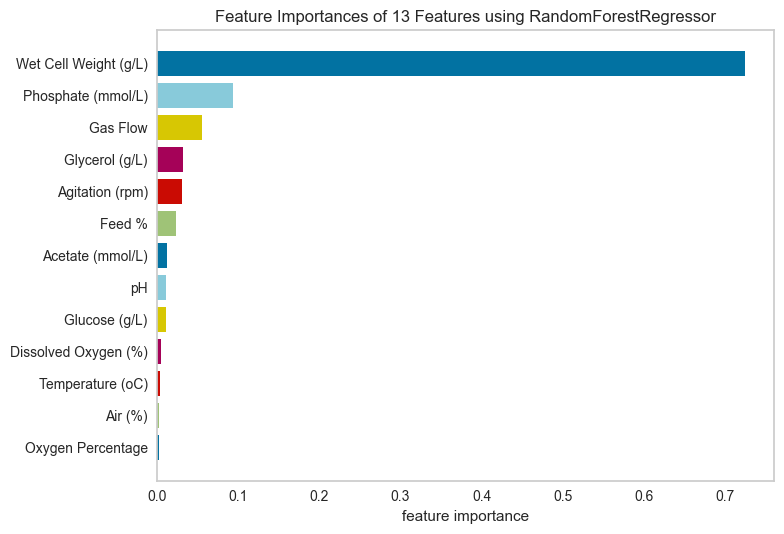

<Axes: title={'center': 'Feature Importances of 13 Features using RandomForestRegressor'}, xlabel='feature importance'>

In [37]:

#OR
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10)

viz = FeatureImportances(model, relative=False)
data_combined = pd.read_csv('data/use_to_code/combined_data_extra.csv', index_col='input_Timepoint (hr)', parse_dates=True)
data_combined = rename_df(data_combined)
viz.fit(data_combined.drop(columns = ['Feed', 'OD600nm']), data_combined['OD600nm'])
# Access the axes object and remove gridlines
viz.ax.grid(False)
viz.show()

In [38]:
# Batch 1: This is the entire dataset. (combined_data.csv or combined_data_extra.csv with missing data imputation)
# df_combined 


In [39]:
# Batch 2: Only clean dataset (removed C1-4,5,6 and all C2 batches)         # Acetate levels were too high for C1-4, 5, 6; Agitation was low, and OD was low.
w0_c123 = ['exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',    
            'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6' ]

data_w_c123 = [df for df in experiment_data if df.name not in w0_c123]
data_w_c123 = pd.concat(data_w_c123)
# save_csv(data_w_c123, 'data/use_to_code/data_w_c123.csv')       # All Data without C1-4,5,6 and C2 batches 
# ---------------------------------------------------------------------------------------------------------------------------


In [40]:
# Batch 3: Fairly Good Data (removed all C2 batches)            # Acetate levels were too high for C1-4, 5, 6
w0_c1 = ['exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6' ]

data_w0_c2 = [df for df in experiment_data if df.name not in w0_c123]
data_w0_c2 = pd.concat(data_w0_c2)
# save_csv(data_w0_c2, 'data/use_to_code/data_w0_c2.csv')         # All Dataframes without C2 batches
# ---------------------------------------------------------------------------------------------------------------------------


In [41]:
# Batch 4: Data with Agitation of 700 rpm (and dropped output glycerol because it was empty)
agi_700 = ['exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6' ]

data_agi_700 = [df for df in experiment_data if df.name in w0_c123]
data_agi_700 = pd.concat(data_agi_700)
data_agi_700 = data_agi_700.drop(columns = 'output_glycerol_gl')
# # save_csv(data_agi_700, 'data/use_to_code/data_agi_700.csv')         # All Dataframes without C2 batches
# # ---------------------------------------------------------------------------------------------------------------------------


In [42]:
# Batch 5: Data with Agitation of 1200 rpm
agi_1200 = ['exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6']

data_agi_1200 = [df for df in experiment_data if df.name not in w0_c123]
data_agi_1200 = pd.concat(data_agi_1200)
# # save_csv(data_agi_1200, 'data/use_to_code/data_agi_1200.csv')         # All Dataframes without C2 batches
# # ---------------------------------------------------------------------------------------------------------------------------


In [43]:
# Batch 6: Entire Data without Glycerol 

data_wo_glycerol = [df for df in experiment_data]
data_wo_glycerol = pd.concat(data_wo_glycerol)
data_wo_glycerol = data_wo_glycerol.drop(columns = 'output_glycerol_gl')
# # save_csv(data_wo_glycerol, 'data/use_to_code/data_wo_glycerol.csv')         # All Dataframes without C2 batches
# # ---------------------------------------------------------------------------------------------------------------------------


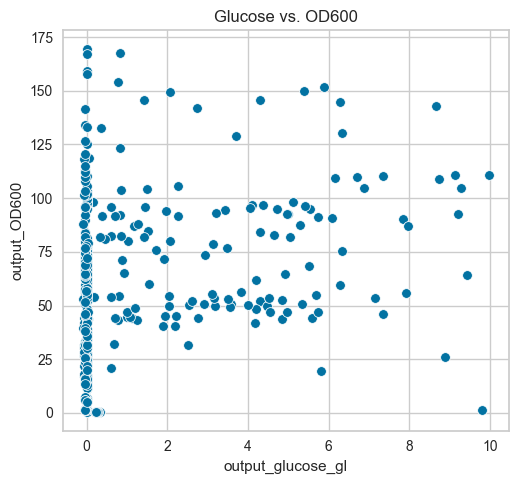

In [44]:

# Scatter plot for Glucose vs. OD600

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# sns.scatterplot(x='output_glycerol_gl', y='output_OD600', data=df_combined)
sns.scatterplot(x='output_glucose_gl', y='output_OD600', data=df_combined.query('output_glucose_gl < 10'))
plt.title('Glucose vs. OD600')
plt.tight_layout()
# plt.savefig("images/scatter_plots/glucose_vs_OD600.png" , dpi = 300)
plt.show()


### Missing Value Imputation

In [45]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


def impute_missing_values_iteratively(X_a): #or (X, Columns)
    
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()
    
    for col in X.columns: 
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':  
            X[col] = pd.to_numeric(X[col], errors='coerce')

    
    imputer = IterativeImputer(
        # estimator = RandomForestRegressor() 
        estimator=RandomForestRegressor(n_estimators=100, random_state=0), # the estimator to predict the NA
        initial_strategy='mean', # how will NA be imputed in step 1
        max_iter=10, # number of cycles
        imputation_order='ascending', # the order in which to impute the variables
        n_nearest_features=None, # whether to limit the number of predictors
        skip_complete=True, # whether to ignore variables without NA
        random_state=0,)
    
    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = X.select_dtypes(include=['number']).columns
    # select only the columns with missing values to be imputed
    # X_cols = X[columns]
    X_imputed = imputer.fit_transform(X[numeric_cols]) #or X_cols
    X_a[numeric_cols] = X_imputed
    
    return X_a



def set_reset_index(df, action: str):
    if action == 'set':
        df_set_reset = df.set_index('input_Timepoint (hr)')
    elif action == 'reset':
        df_set_reset = df.reset_index()
        if 'index' in df_set_reset.columns:
            df_set_reset.drop(columns = 'index', inplace=True)
        # del df['index']
    else:
        print('Invalid action. Please enter either "set" or "reset"')
    return df_set_reset

# reset index
df_combined = set_reset_index(df_combined, action='reset')
data_w_c123 = set_reset_index(data_w_c123, action='reset')
data_w0_c2 = set_reset_index(data_w0_c2, action='reset')
data_agi_700 = set_reset_index(data_agi_700, action='reset')
data_agi_1200 = set_reset_index(data_agi_1200, action='reset')
data_wo_glycerol = set_reset_index(data_wo_glycerol, action='reset')


# perform missing value inputation
df_combined_extra = impute_missing_values_iteratively(df_combined)
data_w_c123_extra = impute_missing_values_iteratively(data_w_c123)
data_w0_c2_extra = impute_missing_values_iteratively(data_w0_c2)
data_agi_700_extra = impute_missing_values_iteratively(data_agi_700)
data_agi_1200_extra = impute_missing_values_iteratively(data_agi_1200)
data_wo_glycerol_extra = impute_missing_values_iteratively(data_wo_glycerol)

# set index
# df_combined_extra = set_reset_index(df_combined_extra, action='set')
# data_w_c123_extra = set_reset_index(data_w_c123_extra, action='set')
# data_w0_c2_extra = set_reset_index(data_w0_c2_extra, action='set')
# data_agi_700_extra = set_reset_index(data_agi_700_extra, action='set')
# data_agi_1200_extra = set_reset_index(data_agi_1200_extra, action='set')
# data_wo_glycerol_extra = set_reset_index(data_wo_glycerol_extra, action='set')



In [46]:
df_combined.columns

Index(['input_Timepoint (hr)', 'output_OD600', 'output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l'], dtype='object')

> Trasforming time variable (using sine and cosine method)

In [49]:

def add_cyclical_time_features(df, time_column, cycle_period):
    """
    Adds cyclical time features to a DataFrame based on a specified time column and cycle period.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time column.
    - time_column (str): The name of the column in df that contains time values.
    - cycle_period (float): The period of the cycle in the same units as the time column (e.g., 48 hours).

    Returns:
    - pd.DataFrame: A DataFrame with two new columns appended, representing the sine and cosine transformations of the time column.
    """
    
    # Ensure the time column exists in the DataFrame
    if time_column not in df.columns:
        raise ValueError(f"The specified time column '{time_column}' does not exist in the DataFrame.")

    # Apply sine and cosine transformations
    df[f'{time_column}_sin'] = np.sin(2 * np.pi * df[time_column] / cycle_period)
    df[f'{time_column}_cos'] = np.cos(2 * np.pi * df[time_column] / cycle_period)
    df.drop(columns = time_column, inplace=True)

    return df

# Example usage
# Assuming your DataFrame is named df and the time column is named 'time'
df_combined_extra = add_cyclical_time_features(df_combined_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)
data_w_c123_extra = add_cyclical_time_features(data_w_c123_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)
data_w0_c2_extra = add_cyclical_time_features(data_w0_c2_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)
data_agi_700_extra = add_cyclical_time_features(data_agi_700_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)
data_agi_1200_extra = add_cyclical_time_features(data_agi_1200_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)
data_wo_glycerol_extra = add_cyclical_time_features(data_wo_glycerol_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)



# Check the first few rows to verify the new columns
plt.figure(figsize=(8, 8))
plt.scatter(df_combined_extra['input_Timepoint (hr)_sin'], df_combined_extra['input_Timepoint (hr)_cos'])
plt.xlabel('Cosine of Time')
plt.ylabel('Sine of Time')
plt.title('Sine and Cosine Transformation of Time')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


ValueError: The specified time column 'input_Timepoint (hr)' does not exist in the DataFrame.

In [48]:
def save_csv(df, name_path:str):
    df.to_csv(name_path, index=True) 
    print(f"Data saved to {name_path}")
    
# save_csv(df_combined, r"data/use_to_code/combined_data.csv")              
# save_csv(df_combined_extra, r"data/use_to_code/combined_data_extra.csv")

# save_csv(data_w_c123_extra, r"data/use_to_code/data_w_c123_extra.csv")
# save_csv(data_w0_c2_extra, r"data/use_to_code/data_w0_c2_extra.csv")

In [50]:
df_combined_extra

,output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,input_Timepoint (hr)_sin,input_Timepoint (hr)_cos
0,0.353000,0.000,1185.440000,100.000000,96.810000,5.010000,0.000000,6.910000,0.00,0.00000,30.19,6.4300,0.243000,1.9500,18.0000,0.000000e+00,1.000000e+00
1,0.547000,0.000,1185.320000,100.000000,97.950000,5.000000,0.000000,6.775341,0.00,0.00000,29.99,5.2310,0.181900,3.7795,21.8014,2.588190e-01,9.659258e-01
2,1.590000,0.000,1185.220000,100.000000,94.600000,5.000000,0.000000,6.850000,0.00,0.00000,30.01,6.4305,-0.004392,9.5241,27.5919,5.000000e-01,8.660254e-01
3,4.460000,56.805,1184.830000,100.000000,82.450000,5.000000,0.000000,6.780000,0.00,0.00000,30.04,4.0480,-0.005319,15.6948,25.3705,7.071068e-01,7.071068e-01
4,11.320000,51.770,1184.500000,100.000000,66.110000,5.000000,0.000000,6.710000,0.00,0.00000,29.99,0.0000,0.000000,15.6100,14.4700,8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,83.600000,207.500,1184.912964,99.576492,40.890980,4.793379,0.422386,6.194422,10.60,0.36040,25.99,0.2718,19.202700,4.0200,-0.0100,-8.660254e-01,-5.000000e-01
680,87.400000,208.500,1184.800049,99.456673,40.179340,4.711772,0.543087,6.226009,9.01,0.30634,26.00,0.0097,18.399210,2.7800,-0.0200,-1.000000e+00,-1.836970e-16
681,93.266667,217.500,1184.574951,99.654694,40.592091,4.850256,0.344494,6.214839,7.66,0.26044,26.01,0.1204,16.133740,4.1000,-0.0300,-8.660254e-01,5.000000e-01
682,93.400000,216.500,1185.463989,99.543571,37.069462,4.800520,0.463291,6.221002,6.32,0.21488,25.98,0.0099,11.673240,4.8400,-0.1100,-5.000000e-01,8.660254e-01


### Variable Transformation - apply to train, and then to test

In [ ]:
#the decision to scale or transform a variable should be based on its distribution, relationship with the 
# target variable, and domain knowledge. Scaling is not necessary if the variable follows a normal or approximately 
# normal distribution 

In [ ]:
# #Variable transformation involves transforming the values of variables to make them more suitable for analysis
# #the idea is to make the variables normally/gaussian distributed. Hence, 

# #first step is to assess normality using a histogram or QQ-plot (to explore the variable distribution)

# def diagnostic_plots(df, variable):

#     # function to plot a histogram and a Q-Q plot
#     # side by side, for a certain variable

#     plt.figure(figsize=(15, 6))

#     # histogram
#     plt.subplot(1, 2, 1)
#     df[variable].hist(bins=30)
#     plt.title(f"Histogram of {variable}")

#     # q-q plot
#     plt.subplot(1, 2, 2)
#     stats.probplot(df[variable], dist="norm", plot=plt)
#     plt.title(f"Q-Q plot of {variable}")

#     # check for skewness
#     skewness = df[variable].skew()
#     if skewness > 0:
#         skew_type = "positively skewed"
#     elif skewness < 0:
#         skew_type = "negatively skewed"
#     else:
#         skew_type = "approximately symmetric"
        
#     # print message indicating skewness type
#     print(f"The variable {variable} is {skew_type} (skewness = {skewness:.2f})")
    
#     plt.show()

# # # Check function output
# # diagnostic_plots(X, "MedInc")


# #use this to make diagnostics plot for all variables
# for feature in continuous_feature:
#     print(feature)
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     df[feature].hist()
#     plt.subplot(1, 2, 2)
#     stats.probplot(df[feature], dist="norm", plot=plt) 
#     plt.show()

In [ ]:
# def qq_plots(df, variable):     
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     df[variable].hist()
#     plt.subplot(1, 2, 2)
#     stats.probplot(df[variable], dist="norm", plot=plt)
#     plt.show()

# for feature in continuous_feature:
#     print(feature)
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     df[feature].hist()
#     plt.subplot(1, 2, 2)
#     stats.probplot(df[feature], dist="norm", plot=plt)
#     plt.show()

In [ ]:
# #If the variables are NOT normally distributed, we then transform it. It is necessary to test several variable 
# # transformation methods, and choose the best for that feature. One variable transformation method is log_transform

# #NB: if data is positively skewed (right skewed), use (logarithmic, reciprocal, or square root transformation)
#     #if data is negatively skewed (left skewed), use (Box-Cox or Yeo-Johnson transformations)
# #log transform 
# def log_transform(df, columns):
#     """
#     Transforms specified columns of a pandas DataFrame using the natural logarithm function.

#     Parameters:
#     -----------
#     df : pandas DataFrame
#         The DataFrame to transform.
#     columns : list
#         A list of column names to transform.

#     Returns:
#     --------
#     pandas DataFrame
#         The transformed DataFrame.
#     """
#     transformer = FunctionTransformer(np.log1p, validate=True)
#     X = df.values.copy()
#     X[:, df.columns.isin(columns)] = transformer.transform(X[:, df.columns.isin(columns)])
#     X_log = pd.DataFrame(X, index=df.index, columns=df.columns)
#     return X_log

# #perform transformation on the variables that are not normally distributed
# X_train = log_transform(X_train, columns = ['Vp', 'Caliper'])
# X_val = log_transform(X_val, columns = ['Vp', 'Caliper'])
# X_test = log_transform(X_test, columns = ['Vp', 'Caliper']) 

In [ ]:
# diagnostic_plots(df_log, columns) 

## Model Building

In [ ]:
# # Scale the features.
# # =============================================================================
# # This script is used to scale the features of the dataset. The scaling process is important to ensure that the features are on a similar scale,
# from sklearn.preprocessing import StandardScaler, MinMaxScaler


# # X, y = df_combined_extra.drop(columns=['output_OD600']), df_combined_extra  # Assuming X is the feature matrix and y is the target vector

# # Use StandardScaler for this

# def scale_and_concat(X, columns_to_transform, train = False, scaler = None):
#     """
#     Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

#     Args:
#         df (pandas.DataFrame): The DataFrame containing the data.
#         columns_to_transform (list): List of column names to be scaled.

#     Returns:
#         pandas.DataFrame: The concatenated DataFrame with scaled columns.
#     """
#     if train == True:
#         scaler = MinMaxScaler() # Initialize the scaler
#         scaler.fit(X[columns_to_transform])  # Fit only on the training set
#     else:
#         scaler = scaler

#     # Create a copy of the original DataFrame
#     df_concatenated = X.copy()

#     # Scale the selected columns
#     scaled_columns = scaler.transform(X[columns_to_transform])

#     # Create a DataFrame with the scaled columns
#     df_scaled = pd.DataFrame(scaled_columns, columns=columns_to_transform, index=X.index)

#     # Concatenate the scaled columns with the rest of the DataFrame
#     df_concatenated = pd.concat([df_concatenated.drop(columns=columns_to_transform, axis = 1), df_scaled], axis=1)

#     if train == True:
#         return df_concatenated, scaler
#     else:
#         return df_concatenated



# X_train, scaler = scale_and_concat(X_train, X_train.columns, train = True)
# X_test = scale_and_concat(X_test, X_test.columns, train = False, scaler = scaler)

# X_train_c123, scaler_c123 = scale_and_concat(X_train_c123, X_train_c123.columns, train = True)
# X_test_c123 = scale_and_concat(X_test_c123, X_test_c123.columns, train = False, scaler = scaler_c123)

# X_train_w0c2, scaler_w0c2 = scale_and_concat(X_train_w0c2, X_train_w0c2.columns, train = True)
# X_test_w0c2 = scale_and_concat(X_test_w0c2, X_test_w0c2.columns, train = False, scaler = scaler_w0c2)



In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this

def scale_and_concat(X, columns_to_transform, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        scaler = MinMaxScaler() # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    


class custom_cv:
    def __init__(self, n_splits, train_percent = 0.7):
        self.n_splits = n_splits
        self.train_percent = train_percent

    def split(self, X):
        # Calculate the number of time points per split based on the total duration and number of splits
        time_points_per_split = len(X) // self.n_splits

        X.reset_index(inplace=True, drop=True)
        for i in range(self.n_splits):
            # Determine the start and end indices for each split
            start_idx = i * time_points_per_split
            end_idx = start_idx + time_points_per_split

            # Calculate the index for splitting the train and test sets within the current split
            # This is based on the proportion of the train_duration_hours to the total_duration_hours
            split_idx = start_idx + int(time_points_per_split * self.train_percent)

            # Ensure the end index does not exceed the length of the DataFrame
            end_idx = min(end_idx, len(X) - 1)

            # Generate training and testing indices
            tr_idx = X.index[start_idx:split_idx]
            te_idx = X.index[split_idx:end_idx + 1]

            yield tr_idx, te_idx



# class custom_cv:
#     def __init__(self, experiment_duration, train_duration, n_splits):
#         self.experiment_duration = pd.Timedelta(hours=experiment_duration)
#         self.train_duration = pd.Timedelta(hours=train_duration)
#         self.n_splits = n_splits

#     def split(self, X):
#         self.X = X
#         for i in range(self.n_splits):
#             # Calculate the datetime for start and end of each experiment
#             exp_start = self.X.index[0] + i * self.experiment_duration
#             train_end = exp_start + self.train_duration
#             test_end = exp_start + self.experiment_duration

#             # Create indices for training and testing based on calculated thresholds
#             tr_idx = self.X.index[(self.X.index >= exp_start) & (self.X.index <= train_end)]
#             te_idx = self.X.index[(self.X.index > train_end) & (self.X.index < test_end)]

#             yield tr_idx, te_idx

            
    
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Assuming y_train and X_train are defined and contain your training data
def fit_sarimax_model(X_train, y_train, X_test, y_test, action="set"):
    if action == "set":
        if (
            "input_Timepoint (hr)" in X_train.columns
            or "input_Timepoint (hr)" in X_test.columns
        ):
            X_train = set_reset_index(X_train, action=action)
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_train = set_reset_index(X_train, action=action)
        X_test = set_reset_index(X_test, action=action)

    # Define the model
    model = SARIMAX(
        y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
    )
    # Fit the model
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(
        steps=len(X_test), exog=X_test
    ).predicted_mean.values
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for SARIMAX: {mse}")
    # print(f"Root Mean Squared Error for SARIMAX: {rmse}")
    # print(f"R2 for SARIMAX: {r2}")
    return mse, rmse, r2, model_fit


# Function for XGBoost regression
def train_evaluate_xgboost(X_train, y_train, X_test, y_test, params, action="reset"):
    if action == "set":
        if (
            "input_Timepoint (hr)" in X_train.columns
            or "input_Timepoint (hr)" in X_test.columns
        ):
            X_train = set_reset_index(X_train, action=action)
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_train = set_reset_index(X_train, action=action)
        X_test = set_reset_index(X_test, action=action)
    # Instantiate the XGBoost regressor with the given parameters
    xg_reg = xgb.XGBRegressor(**params)
    xg_reg.fit(X_train, y_train)

    # Predictions
    y_pred = xg_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for XGBoost: {mse}")
    # print(f"Root Mean Squared Error for XGBoost: {rmse}")
    # print(f"R2 for XGBoost: {r2}")
    return mse, rmse, r2, xg_reg


# Function for Multiple Linear Regression
def train_evaluate_linear_regression(X_train, y_train, X_test, y_test, action="reset"):
    if action == "set":
        if (
            "input_Timepoint (hr)" in X_train.columns
            or "input_Timepoint (hr)" in X_test.columns
        ):
            X_train = set_reset_index(X_train, action=action)
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_train = set_reset_index(X_train, action=action)
        X_test = set_reset_index(X_test, action=action)
    # Instantiate the Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predictions
    y_pred = lin_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for Linear Regression: {mse}")
    # print(f"Root Mean Squared Error for Linear Regression: {rmse}")
    # print(f"R2 for Linear Regression: {r2}")
    return mse, rmse, r2, lin_reg




> Timeseries using tcsv cross-validation

In [ ]:
import neptune # Import the neptune library
# import neptune.new as neptune 
from neptune.new.types import File
import joblib 



def timeseries_cv_with_scaling(df, n_splits=5, model_name = 'xgboost', action = 'set', params = None):        # use action = 'set' for SARIMAX
    """
    Perform time series cross-validation with scaling inside the CV loop.
    
    Parameters:
    - X: Features dataframe
    - y: Target variable series
    - n_splits: Number of splits for the time series cross-validation
    
    Returns:
    - scores: A list of scores for each fold
    """
    
    # Initialize Neptune run
    run = neptune.init_run(project='gra-research/cytovance-research', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMTM4MWQyYS00ZTgxLTQ5M2EtOTVkOC1mNGMyMjQxOTg0ZTAifQ==')
    
    # Neptune: Log the dataset
    run['data/train_dataset'].upload(File.as_pickle(df))

    # Neptune: Log the cross-validation parameters
    run['cv_params'] = {
        'n_splits': n_splits,
        'model': model,
        'action': action
    }
    
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores, rmse_scores, r2_scores, models = [], [], [], []
    X = df.drop(columns=['output_OD600'])  # Features (exclude the target variable)
    y = df['output_OD600'].values  # Target variable
    
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(X)):
        
        # Splitting the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        X_train_scaled, scaler = scale_and_concat(X_train, X_train.columns, train = True, scaler = None)
        X_test_scaled = scale_and_concat(X_test, X_test.columns, train = False, scaler = scaler)
        
        # Modeling
        if model_name == 'xgboost':
            mse, rmse, r2, xg_reg = train_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, params = params, action='set')
            
            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2
            run[f'fold_{fold_idx}/params'] = xg_reg.get_xgb_params() # Log the model parameters
    
            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(xg_reg, f'models/{model_filename}')
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(xg_reg)  # Save the model object
            
        elif model_name == 'linear':
            mse, rmse, r2, lin_reg = train_evaluate_linear_regression(X_train_scaled, y_train, X_test_scaled, y_test, action='set')

            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2
            
            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(lin_reg, f'models/{model_filename}')
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(lin_reg)  # Save the model object
            
        elif model_name == 'sarimax':
            mse, rmse, r2, model_fit = fit_sarimax_model(X_train_scaled, y_train, X_test_scaled, y_test, action='set')

            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2

            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(model_fit, f'models/{model_filename}') # Save the model
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(model_fit)  # Save the model object
                     
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
    # Neptune: Log average metrics across all folds
    run[f'average/{model_name}/mse'] = sum(mse_scores) / len(mse_scores)
    run[f'average/{model_name}/rmse'] = sum(rmse_scores) / len(rmse_scores)
    run[f'average/{model_name}/r2'] = sum(r2_scores) / len(r2_scores)
    
    # Neptune: Stop the run
    run.stop()
    return mse_scores, rmse_scores, r2_scores, models



data = [df_combined_extra, data_w_c123_extra, data_w0_c2_extra, data_agi_700_extra, data_agi_1200_extra, data_wo_glycerol_extra] 
data_name = ['df_combined_extra', 'data_w_c123_extra', 'data_w0_c2_extra', 'data_agi_700_extra', 'data_agi_1200_extra', 'data_wo_glycerol_extra']
 
for i, df in enumerate(data):
    df.name = data_name[i]
    
models = ['xgboost', 'linear', 'sarimax']  

params = {'objective':'reg:squarederror', 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'n_estimators': 10}


# Initialize Neptune run
run = neptune.init_run(project='gra-research/cytovance-research', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMTM4MWQyYS00ZTgxLTQ5M2EtOTVkOC1mNGMyMjQxOTg0ZTAifQ==')

# Loop to perform cross-validation on each dataset with each model
best_models_files = {}
for i, dataset in enumerate(data):
    print('Dataset Used: ', dataset.name) # Print the name of the dataset being used for this iteration
    for model_name in models:
        mse_scores, rmse_scores, r2_scores, trained_models = timeseries_cv_with_scaling(dataset, n_splits=5, model_name=model_name, action='reset', params=params)

        print(f"Cross-validation Mean Squared Error for {model_name} on data {i+1}:", np.mean(mse_scores))
        print(f"Cross-validation Root Mean Squared Error for {model_name} on data {i+1}:", np.mean(rmse_scores))
        print(f"Cross-validation R2 for {model_name} on data {i+1}:", np.mean(r2_scores))
        
        # Find the best model based on average RMSE
        average_rmse = np.mean(rmse_scores)
        if i not in best_models_files or best_models_files[i][1] > average_rmse:
            best_model_idx = np.argmin(rmse_scores)  # Index of the best model in this run
            best_model = trained_models[best_model_idx]
            
            # Save the best model
            model_filename = f'models/best_model_dataset_{i+1}_{model_name}.pkl'
            joblib.dump(best_model, model_filename)
            
            best_models_files[i] = (model_name, average_rmse, model_filename)

# Log the best models to Neptune
for i, (model_name, rmse, model_filename) in best_models_files.items():
    run[f'best_model/dataset_{i+1}/name'] = model_name
    run[f'best_model/dataset_{i+1}/rmse'] = rmse
    run[f'best_model/dataset_{i+1}/file'].upload(model_filename)

run.stop()

https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-185
df_combined_extra
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-186
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 51 operations to synchronize with Neptune. Do not kill this process.
All 51 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-186/metadata
Cross-validation Mean Squared Error for xgboost on data 1: 878.381238361435
Cross-validation Root Mean Squared Error for xgboost on data 1: 28.09560314983334
Cross-validation R2 for xgboost on data 1: 0.6236208508087124
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-187
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 26 operations to synchronize with Neptune. Do not kill this process.
All 26 operations synced, thanks for waiting!
Explore the metadata in 

> Timeseries using custom Cross-validation function

In [ ]:
import joblib 
import neptune # Import the neptune library
# import neptune.new as neptune 
from neptune.new.types import File


def timeseries_cv_with_scaling_custom(df, n_splits=5, total_duration_hours = 48, train_duration_hours = 36, model_name='xgboost', action='reset', params=None):
    """
    Perform time series cross-validation with scaling inside the CV loop, using custom CV splits.

    Parameters:
    - df: DataFrame containing features and target variable
    - n_splits: Number of splits for the custom time series cross-validation
    - train_end: The last period in the training set
    - test_size: The size of each test set
    - model_name: The name of the model to use ('xgboost', 'linear', 'sarimax')
    - action: Additional action parameter for model training, if needed
    - params: Model parameters
    
    Returns:
    - scores: A list of scores for each fold
    """
    
    # Initialize Neptune run
    run = neptune.init_run(project='gra-research/cytovance-research', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMTM4MWQyYS00ZTgxLTQ5M2EtOTVkOC1mNGMyMjQxOTg0ZTAifQ==')
    
    # Neptune: Log the dataset
    run['data/train_dataset'].upload(File.as_pickle(df))

    # Neptune: Log the cross-validation parameters
    run['cv_params'] = {
        'n_splits': n_splits,
        'model_name': model_name,
        'action': action
    }
    
    # Initialize custom CV object
    custom_cv_obj = custom_cv(n_splits=n_splits, train_percent = 0.7)

    
    # Initialize scores and models list
    mse_scores, rmse_scores, r2_scores, models = [], [], [], []
    
    # Separate features and target
    X = df.drop(columns=['output_OD600'])  # Features
    y = df['output_OD600']  # Target
    
    # Use custom_cv for splitting
    for fold_idx, (train_index, test_index) in enumerate(custom_cv_obj.split(X)):
        # Splitting the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        X_train_scaled, scaler = scale_and_concat(X_train, X_train.columns, train = True, scaler = None)
        X_test_scaled = scale_and_concat(X_test, X_test.columns, train = False, scaler = scaler)
        
        # Modeling
        if model_name == 'xgboost':
            mse, rmse, r2, xg_reg = train_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, params = params, action='set')
            
            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2
            run[f'fold_{fold_idx}/params'] = xg_reg.get_xgb_params() # Log the model parameters
    
            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(xg_reg, f'models/{model_filename}')
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(xg_reg)  # Save the model object
            
        elif model_name == 'linear':
            mse, rmse, r2, lin_reg = train_evaluate_linear_regression(X_train_scaled, y_train, X_test_scaled, y_test, action='set')

            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2
            
            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(lin_reg, f'models/{model_filename}')
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(lin_reg)  # Save the model object
            
        elif model_name == 'sarimax':
            mse, rmse, r2, model_fit = fit_sarimax_model(X_train_scaled, y_train, X_test_scaled, y_test, action='set')

            # Neptune: Log metrics for each fold
            run[f'fold_{fold_idx}/mse'] = mse
            run[f'fold_{fold_idx}/rmse'] = rmse
            run[f'fold_{fold_idx}/r2'] = r2

            model_filename = f'{model_name}_model_{fold_idx}.pkl'
            joblib.dump(model_fit, f'models/{model_filename}') # Save the model
            run[f'fold_{fold_idx}/model'].upload(f'models/{model_filename}')
            models.append(model_fit)  # Save the model object
                     
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
    # Neptune: Log average metrics across all folds
    run[f'average/{model_name}/mse'] = sum(mse_scores) / len(mse_scores)
    run[f'average/{model_name}/rmse'] = sum(rmse_scores) / len(rmse_scores)
    run[f'average/{model_name}/r2'] = sum(r2_scores) / len(r2_scores)
    
    # Neptune: Stop the run
    run.stop()
    return mse_scores, rmse_scores, r2_scores, models



# data = [df_combined_extra, data_w_c123_extra, data_w0_c2_extra, data_agi_700_extra, data_agi_1200_extra, data_wo_glycerol_extra]

    
models = ['xgboost', 'linear']  

params = {'objective':'reg:squarederror', 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'n_estimators': 10}


# Initialize Neptune run
run = neptune.init_run(project='gra-research/cytovance-research', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMTM4MWQyYS00ZTgxLTQ5M2EtOTVkOC1mNGMyMjQxOTg0ZTAifQ==')

n_splits = 5  # Number of splits you want in your cross-validation
total_duration_hours = 48  # Total duration covered by your dataset (or the duration you want to consider for each split)
train_duration_hours = 36  # Number of hours you want to allocate for training in each split


# Loop to perform cross-validation on each dataset with each model
best_models_files = {}
for i, dataset in enumerate(data):
    print('Dataset Used: ', dataset.name) # Print the name of the dataset being used for this iteration 
    for model_name in models:
        mse_scores, rmse_scores, r2_scores, trained_models = timeseries_cv_with_scaling_custom (dataset, n_splits=n_splits, total_duration_hours = total_duration_hours, train_duration_hours = train_duration_hours, model_name=model_name, action='reset', params=params)

        print(f"Cross-validation Mean Squared Error for {model_name} on data {i+1}:", np.mean(mse_scores))
        print(f"Cross-validation Root Mean Squared Error for {model_name} on data {i+1}:", np.mean(rmse_scores))
        print(f"Cross-validation R2 for {model_name} on data {i+1}:", np.mean(r2_scores))
        
        # Find the best model based on average RMSE
        average_rmse = np.mean(rmse_scores)
        if i not in best_models_files or best_models_files[i][1] > average_rmse:
            best_model_idx = np.argmin(rmse_scores)  # Index of the best model in this run
            best_model = trained_models[best_model_idx]
            
            # Save the best model
            model_filename = f'models/best_model_dataset_{i+1}_{model_name}.pkl'
            joblib.dump(best_model, model_filename)
            
            best_models_files[i] = (model_name, average_rmse, model_filename)

# Log the best models to Neptune
for i, (model_name, rmse, model_filename) in best_models_files.items():
    run[f'best_model/dataset_{i+1}/name'] = model_name
    run[f'best_model/dataset_{i+1}/rmse'] = rmse
    run[f'best_model/dataset_{i+1}/file'].upload(model_filename)




https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-153
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-154
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 52 operations to synchronize with Neptune. Do not kill this process.
All 52 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-154/metadata
Cross-validation Mean Squared Error for xgboost on data 1: 712.0480965811075
Cross-validation Root Mean Squared Error for xgboost on data 1: 25.111687987986542
Cross-validation R2 for xgboost on data 1: 0.6723756112993577
https://app.neptune.ai/gra-research/cytovance-research/e/OBINOPAUL-155
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.
All 27 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:

> Using Pycaret

In [ ]:
df_combined_extra

,output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,input_Timepoint (hr)_sin,input_Timepoint (hr)_cos
0,0.353000,0.000,1185.440000,100.000000,96.810000,5.010000,0.000000,6.910000,0.00,0.00000,30.19,6.4300,0.243000,1.9500,18.0000,0.000000e+00,1.000000e+00
1,0.547000,0.000,1185.320000,100.000000,97.950000,5.000000,0.000000,6.775341,0.00,0.00000,29.99,5.2310,0.181900,3.7795,21.8014,2.588190e-01,9.659258e-01
2,1.590000,0.000,1185.220000,100.000000,94.600000,5.000000,0.000000,6.850000,0.00,0.00000,30.01,6.4305,-0.004392,9.5241,27.5919,5.000000e-01,8.660254e-01
3,4.460000,56.805,1184.830000,100.000000,82.450000,5.000000,0.000000,6.780000,0.00,0.00000,30.04,4.0480,-0.005319,15.6948,25.3705,7.071068e-01,7.071068e-01
4,11.320000,51.770,1184.500000,100.000000,66.110000,5.000000,0.000000,6.710000,0.00,0.00000,29.99,0.0000,0.000000,15.6100,14.4700,8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,83.600000,207.500,1184.912964,99.576492,40.890980,4.793379,0.422386,6.194422,10.60,0.36040,25.99,0.2718,19.202700,4.0200,-0.0100,-8.660254e-01,-5.000000e-01
680,87.400000,208.500,1184.800049,99.456673,40.179340,4.711772,0.543087,6.226009,9.01,0.30634,26.00,0.0097,18.399210,2.7800,-0.0200,-1.000000e+00,-1.836970e-16
681,93.266667,217.500,1184.574951,99.654694,40.592091,4.850256,0.344494,6.214839,7.66,0.26044,26.01,0.1204,16.133740,4.1000,-0.0300,-8.660254e-01,5.000000e-01
682,93.400000,216.500,1185.463989,99.543571,37.069462,4.800520,0.463291,6.221002,6.32,0.21488,25.98,0.0099,11.673240,4.8400,-0.1100,-5.000000e-01,8.660254e-01


In [ ]:
# df_combined_extra

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(684, 17)"
4,Transformed data shape,"(684, 17)"
5,Transformed train set shape,"(478, 17)"
6,Transformed test set shape,"(206, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0412,0.0060,0.0675,0.8965,0.0443,1.2468,0.2600
xgboost,Extreme Gradient Boosting,0.0425,0.0069,0.0704,0.8821,0.0469,1.9348,0.0680
gbr,Gradient Boosting Regressor,0.0446,0.0071,0.0712,0.8760,0.0467,1.0956,0.0570
rf,Random Forest Regressor,0.0447,0.0070,0.0723,0.8761,0.0476,3.1623,0.0440
lightgbm,Light Gradient Boosting Machine,0.0450,0.0068,0.0716,0.8848,0.0476,23.1279,0.0750
huber,Huber Regressor,0.0459,0.0061,0.0677,0.8977,0.0456,13.4169,0.0130
dt,Decision Tree Regressor,0.0464,0.0076,0.0771,0.8553,0.0513,3.7683,0.0110
br,Bayesian Ridge,0.0466,0.0068,0.0706,0.8846,0.0478,5.9899,0.0100
ada,AdaBoost Regressor,0.0472,0.0074,0.0726,0.8731,0.0479,7.3824,0.0460
knn,K Neighbors Regressor,0.0504,0.0079,0.0760,0.8605,0.0506,0.8298,0.0260


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(477, 17)"
4,Transformed data shape,"(477, 17)"
5,Transformed train set shape,"(333, 17)"
6,Transformed test set shape,"(144, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0347,0.0032,0.0494,0.9362,0.0329,20.7546,0.0160
br,Bayesian Ridge,0.0354,0.0033,0.0495,0.9301,0.0331,14.1710,0.0150
et,Extra Trees Regressor,0.0359,0.0047,0.0556,0.8958,0.0358,1.2601,0.0460
gbr,Gradient Boosting Regressor,0.0373,0.0051,0.0547,0.8815,0.0353,1.2719,0.0400
knn,K Neighbors Regressor,0.0374,0.0046,0.0575,0.8985,0.0378,0.8970,0.0360
ada,AdaBoost Regressor,0.0378,0.0046,0.0556,0.8971,0.0362,10.8732,0.0300
rf,Random Forest Regressor,0.0385,0.0049,0.0573,0.8881,0.0371,1.9659,0.0590
ridge,Ridge Regression,0.0400,0.0041,0.0592,0.9139,0.0396,19.7142,0.0120
xgboost,Extreme Gradient Boosting,0.0410,0.0054,0.0599,0.8742,0.0401,1.5669,0.0530
dt,Decision Tree Regressor,0.0440,0.0064,0.0692,0.8517,0.0462,0.5558,0.0140


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(477, 17)"
4,Transformed data shape,"(477, 17)"
5,Transformed train set shape,"(333, 17)"
6,Transformed test set shape,"(144, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0347,0.0032,0.0494,0.9362,0.0329,20.7546,0.0200
br,Bayesian Ridge,0.0354,0.0033,0.0495,0.9301,0.0331,14.1710,0.0120
et,Extra Trees Regressor,0.0359,0.0047,0.0556,0.8958,0.0358,1.2601,0.0530
gbr,Gradient Boosting Regressor,0.0373,0.0051,0.0547,0.8815,0.0353,1.2719,0.0490
knn,K Neighbors Regressor,0.0374,0.0046,0.0575,0.8985,0.0378,0.8970,0.0310
ada,AdaBoost Regressor,0.0378,0.0046,0.0556,0.8971,0.0362,10.8732,0.0330
rf,Random Forest Regressor,0.0385,0.0049,0.0573,0.8881,0.0371,1.9659,0.0590
ridge,Ridge Regression,0.0400,0.0041,0.0592,0.9139,0.0396,19.7142,0.0130
xgboost,Extreme Gradient Boosting,0.0410,0.0054,0.0599,0.8742,0.0401,1.5669,0.0460
dt,Decision Tree Regressor,0.0440,0.0064,0.0692,0.8517,0.0462,0.5558,0.0140


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(207, 16)"
4,Transformed data shape,"(207, 16)"
5,Transformed train set shape,"(144, 16)"
6,Transformed test set shape,"(63, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0695,0.0151,0.0976,0.6367,0.0664,0.5135,0.0460
ada,AdaBoost Regressor,0.0822,0.0218,0.1236,0.5629,0.0817,1.9720,0.0320
knn,K Neighbors Regressor,0.0830,0.0195,0.1189,0.5097,0.0811,1.0459,0.0150
gbr,Gradient Boosting Regressor,0.0857,0.0229,0.1275,0.5374,0.0844,0.7223,0.0290
xgboost,Extreme Gradient Boosting,0.0901,0.0256,0.1351,0.4499,0.0914,0.3626,0.0420
rf,Random Forest Regressor,0.0909,0.0219,0.1293,0.5286,0.0865,1.0489,0.0550
br,Bayesian Ridge,0.0974,0.0200,0.1235,0.5654,0.0847,5.7001,0.0140
ridge,Ridge Regression,0.0992,0.0218,0.1275,0.5315,0.0870,4.8489,0.0120
dt,Decision Tree Regressor,0.1066,0.0326,0.1570,0.3424,0.1055,0.8708,0.0120
huber,Huber Regressor,0.1071,0.0275,0.1426,0.4173,0.0964,4.5759,0.0190


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(477, 17)"
4,Transformed data shape,"(477, 17)"
5,Transformed train set shape,"(333, 17)"
6,Transformed test set shape,"(144, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0347,0.0032,0.0494,0.9362,0.0329,20.7546,0.0240
br,Bayesian Ridge,0.0354,0.0033,0.0495,0.9301,0.0331,14.1710,0.0150
et,Extra Trees Regressor,0.0359,0.0047,0.0556,0.8958,0.0358,1.2601,0.0510
gbr,Gradient Boosting Regressor,0.0373,0.0051,0.0547,0.8815,0.0353,1.2719,0.0510
knn,K Neighbors Regressor,0.0374,0.0046,0.0575,0.8985,0.0378,0.8970,0.0840
ada,AdaBoost Regressor,0.0378,0.0046,0.0556,0.8971,0.0362,10.8732,0.0490
rf,Random Forest Regressor,0.0385,0.0049,0.0573,0.8881,0.0371,1.9659,0.0680
ridge,Ridge Regression,0.0400,0.0041,0.0592,0.9139,0.0396,19.7142,0.0120
xgboost,Extreme Gradient Boosting,0.0410,0.0054,0.0599,0.8742,0.0401,1.5669,0.1790
dt,Decision Tree Regressor,0.0440,0.0064,0.0692,0.8517,0.0462,0.5558,0.0130


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(684, 16)"
4,Transformed data shape,"(684, 16)"
5,Transformed train set shape,"(478, 16)"
6,Transformed test set shape,"(206, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0415,0.0060,0.0678,0.8959,0.0447,0.9801,0.0480
xgboost,Extreme Gradient Boosting,0.0442,0.0073,0.0727,0.8713,0.0485,2.1570,0.0570
rf,Random Forest Regressor,0.0442,0.0070,0.0720,0.8768,0.0475,1.7615,0.0660
dt,Decision Tree Regressor,0.0443,0.0070,0.0747,0.8697,0.0492,0.4548,0.0140
lightgbm,Light Gradient Boosting Machine,0.0446,0.0067,0.0710,0.8852,0.0474,21.0862,0.0730
gbr,Gradient Boosting Regressor,0.0449,0.0071,0.0714,0.8774,0.0471,1.5902,0.0440
br,Bayesian Ridge,0.0470,0.0069,0.0712,0.8808,0.0486,10.9779,0.0140
ada,AdaBoost Regressor,0.0484,0.0077,0.0741,0.8675,0.0490,8.7965,0.0300
knn,K Neighbors Regressor,0.0507,0.0079,0.0765,0.8580,0.0514,0.7200,0.0180
huber,Huber Regressor,0.0511,0.0068,0.0720,0.8792,0.0493,5.1152,0.0180


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

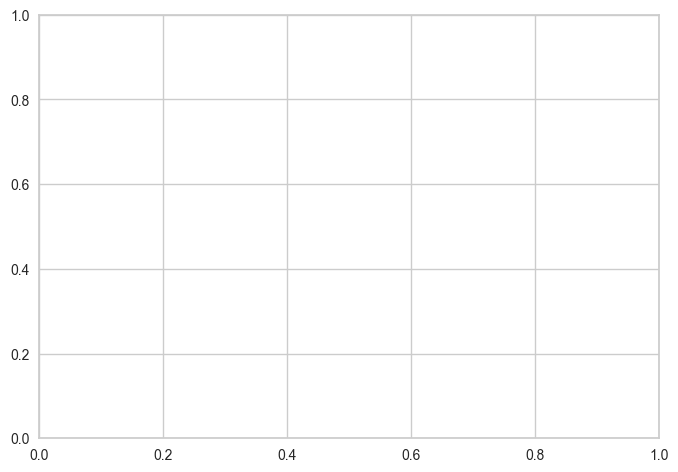

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!


In [ ]:
from pycaret.regression import * 
from pycaret.regression import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, save_model


# data = [df_combined_extra, data_w_c123_extra, data_w0_c2_extra, data_agi_700_extra, data_agi_1200_extra, data_wo_glycerol_extra] 
scale_cols = ['output_OD600', 'output_WCW_gl', 'output_autput_Temp', 'output_glycerol_gl', 'output_glucose_gl', 
              'output_acetate_mmol_l', 'output_phosphate_mmgitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 
              'output_Ph', 'output_feed_%', 'output_feed', 'ool_l']

data = [df_combined_extra, data_w_c123_extra, data_w0_c2_extra, data_agi_700_extra, data_agi_1200_extra, data_wo_glycerol_extra] 
data_name = ['df_combined_extra', 'data_w_c123_extra', 'data_w0_c2_extra', 'data_agi_700_extra', 'data_agi_1200_extra', 'data_wo_glycerol_extra']
 
# Initialize lists to store the scaled DataFrames and scalers
scaled_data = []
scalers = []

for df in data:
    # Scale each DataFrame
    scaled_df, scaler = scale_and_concat(df, scale_cols, train=True)
    
    # Append the scaled DataFrame and scaler to their respective lists
    scaled_data.append(scaled_df)
    scalers.append(scaler)
    
    
for df_2 in scaled_data:
    # df, scaler = scale_and_concat(df, scale_cols, train = True, scaler = None)
    # print('Dataset Used: ', df_2.name) # Print the name of the dataset being used for this iteration 

    # Set fold_strategy to 'timeseries' for time-based cross validation
    # Adjust other parameters as needed
    s = setup(
        data=df_2, 
        target='output_OD600', 
        # index_timeseries=date_index, 
        fold_strategy='timeseries', 
        session_id=123,  # Unique ID for reproducibility
        data_split_shuffle = False,
        fold_shuffle = False
    )

    # all_models = models()   #use this to visualize a table of models available in the model library.

    # Compare models 
    compare_results = compare_models(n_select=7, sort='MAE')    #the best 5 models will be highlighted

    compare_results
    
    # Evaluate each model
    for model in compare_results:
        evaluate_model(model) 


In [ ]:
# Create a model
model = create_model('ridge')     #change knn to any of the top 5 models from above
            # from pycaret.regression import models     #change to classification when needed, then do: exp = setup(X, y)
            # regression_models = models() # Get all regression model estimators  
            # print(regression_models) # Display the list of model names


# # Tune the model
tuned_model = tune_model(model)

# # Evaluate the model
evaluate_model(tuned_model)

# # Fit the model
final_model = tune_model(tuned_model)

# Save the final model in the "ML" folder
model_path = 'models/pycaret_ridge_r2'
save_model(final_model, model_path)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:18:35
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9757,17.2596,4.1545,0.9872,0.1521,0.1898
1,7.8236,142.5371,11.9389,0.8839,0.3187,0.4243
2,2.8672,14.5076,3.8089,0.9837,0.1432,0.1809
3,6.4986,122.8792,11.0851,0.9298,0.1529,0.1366
4,6.3361,83.4974,9.1377,0.9442,0.2974,0.2187
5,14.0773,495.0501,22.2497,0.7948,0.2903,0.2184
6,12.7019,313.1288,17.6954,0.8180,0.3092,0.2793
7,13.2378,407.6767,20.1910,0.8151,0.2484,0.3277
8,19.6186,568.3093,23.8392,0.6507,0.4097,0.6035


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.0104,43.5826,6.6017,0.9676,0.1976,0.3322
1,5.1126,47.3988,6.8847,0.9614,0.2850,0.3621
2,4.3854,52.3020,7.2320,0.9412,0.1748,0.1961
3,6.3486,111.5746,10.5629,0.9362,0.1428,0.1342
4,5.9262,65.0476,8.0652,0.9565,0.2352,0.1782
5,13.9073,486.9633,22.0672,0.7982,0.2538,0.2169
6,11.7986,265.3245,16.2888,0.8458,0.2889,0.2732
7,11.1572,288.9929,16.9998,0.8689,0.2167,0.2619
8,10.3341,224.0599,14.9686,0.8623,0.2406,0.2495


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.0104,43.5826,6.6017,0.9676,0.1976,0.3322
1,5.1126,47.3988,6.8847,0.9614,0.2850,0.3621
2,4.3854,52.3020,7.2320,0.9412,0.1748,0.1961
3,6.3486,111.5746,10.5629,0.9362,0.1428,0.1342
4,5.9262,65.0476,8.0652,0.9565,0.2352,0.1782
5,13.9073,486.9633,22.0672,0.7982,0.2538,0.2169
6,11.7986,265.3245,16.2888,0.8458,0.2889,0.2732
7,11.1572,288.9929,16.9998,0.8689,0.2167,0.2619
8,10.3341,224.0599,14.9686,0.8623,0.2406,0.2495


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['output_WCW_gl',
                                              'output_agitation', 'output_air_%',
                                              'output_D0_%', 'output_gasflow',
                                              'output_O2', 'output_Ph',
                                              'output_feed_%', 'output_feed',
                                              'output_Temp', 'output_glucose_gl',
                                              'output_acetate_mmol_l',
                                              'output_phosphate_mmol_l'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerW

<a id="7"></a> <br>
## Feature Engineering

In [ ]:
# Feature Selection Methods:
    # VarianceThreshold: Remove features with low variance.
    # Univariate Selection: Use methods like SelectKBest, SelectPercentile, or GenericUnivariateSelect.
    # Recursive Feature Elimination: RFE or RFECV (with cross-validation).
    # Model-Based Selection: Use SelectFromModel with L1-based (Lasso, Ridge, ElasticNet) or tree-based methods.
    # Sequential Feature Selector: Forward or backward selection (SFS).
    
# Feature Extraction Methods:
    # Principal Component Analysis (PCA).
    # Independent Component Analysis (ICA).
    # t-Distributed Stochastic Neighbor Embedding (t-SNE).

# Common Choices: PCA for extraction and SelectKBest for selection.

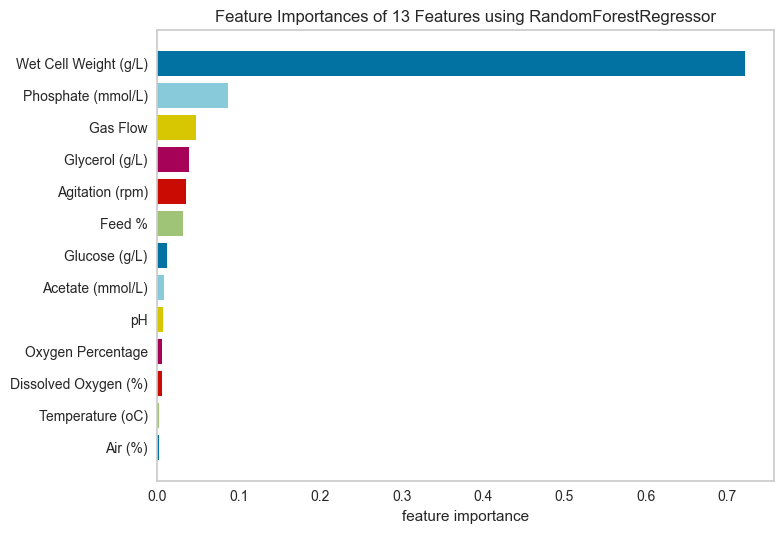

<Axes: title={'center': 'Feature Importances of 13 Features using RandomForestRegressor'}, xlabel='feature importance'>

In [ ]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10)

viz = FeatureImportances(model, relative=False)
data_combined = pd.read_csv('data/use_to_code/combined_data_extra.csv', index_col='input_Timepoint (hr)', parse_dates=True)
data_combined = rename_df(data_combined)
viz.fit(data_combined.drop(columns = ['Feed', 'OD600nm']), data_combined['OD600nm'])
# Access the axes object and remove gridlines
viz.ax.grid(False)
viz.show()

In [ ]:
[df.name for df in data]

['df_combined_extra',
 'data_w_c123_extra',
 'data_w0_c2_extra',
 'data_agi_700_extra',
 'data_agi_1200_extra',
 'data_wo_glycerol_extra']

In [ ]:
df_combined_extra.head()

,output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,input_Timepoint (hr)_sin,input_Timepoint (hr)_cos
0,0.353,0.000,1185.44,100.0,96.81,5.01,0.0,6.910000,0.0,0.0,30.19,6.4300,0.243000,1.9500,18.0000,0.000000,1.000000
1,0.547,0.000,1185.32,100.0,97.95,5.00,0.0,6.775341,0.0,0.0,29.99,5.2310,0.181900,3.7795,21.8014,0.258819,0.965926
2,1.590,0.000,1185.22,100.0,94.60,5.00,0.0,6.850000,0.0,0.0,30.01,6.4305,-0.004392,9.5241,27.5919,0.500000,0.866025
3,4.460,56.805,1184.83,100.0,82.45,5.00,0.0,6.780000,0.0,0.0,30.04,4.0480,-0.005319,15.6948,25.3705,0.707107,0.707107
4,11.320,51.770,1184.50,100.0,66.11,5.00,0.0,6.710000,0.0,0.0,29.99,0.0000,0.000000,15.6100,14.4700,0.866025,0.500000


Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!


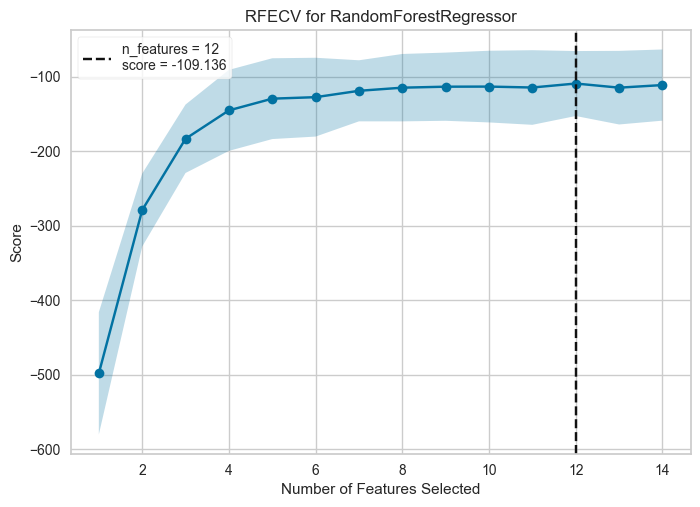

<Axes: title={'center': 'RFECV for RandomForestRegressor'}, xlabel='Number of Features Selected', ylabel='Score'>

In [ ]:
from yellowbrick.model_selection import RFECV 
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestRegressor 


cv = KFold(n_splits=5, shuffle=True, random_state=42)
visualizer = RFECV(RandomForestRegressor(), cv=cv, scoring="neg_mean_squared_error")

visualizer.fit(df_combined_extra.drop(columns = "output_OD600", axis = 1), df_combined_extra['output_OD600'])  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the most important features
important_features = df_combined_extra[['output_WCW_gl', 'output_phosphate_mmol_l', 'output_gasflow', 'output_agitation', 'output_feed_%', 'output_glycerol_gl', 'output_glucose_gl']] #, 'input_Timepoint (hr)' ]]


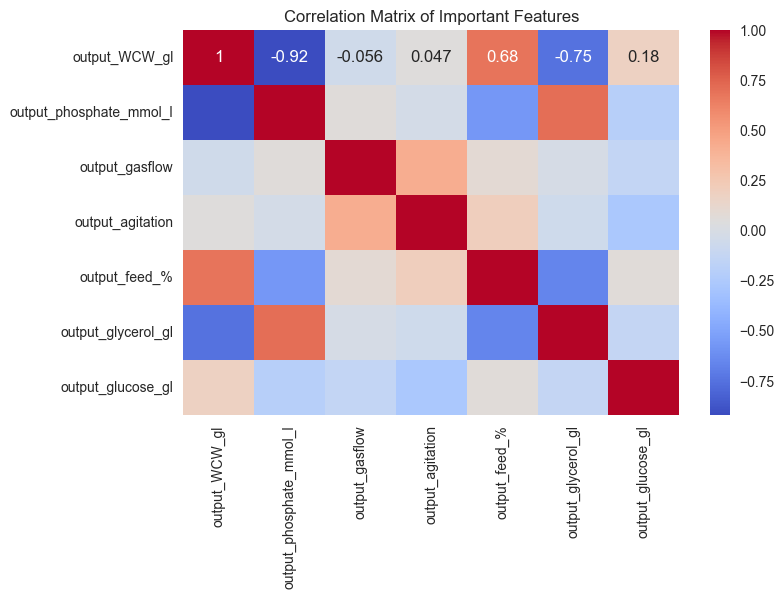

In [ ]:
# Calculate correlation matrix
corr_matrix = important_features.corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Important Features')
plt.show()


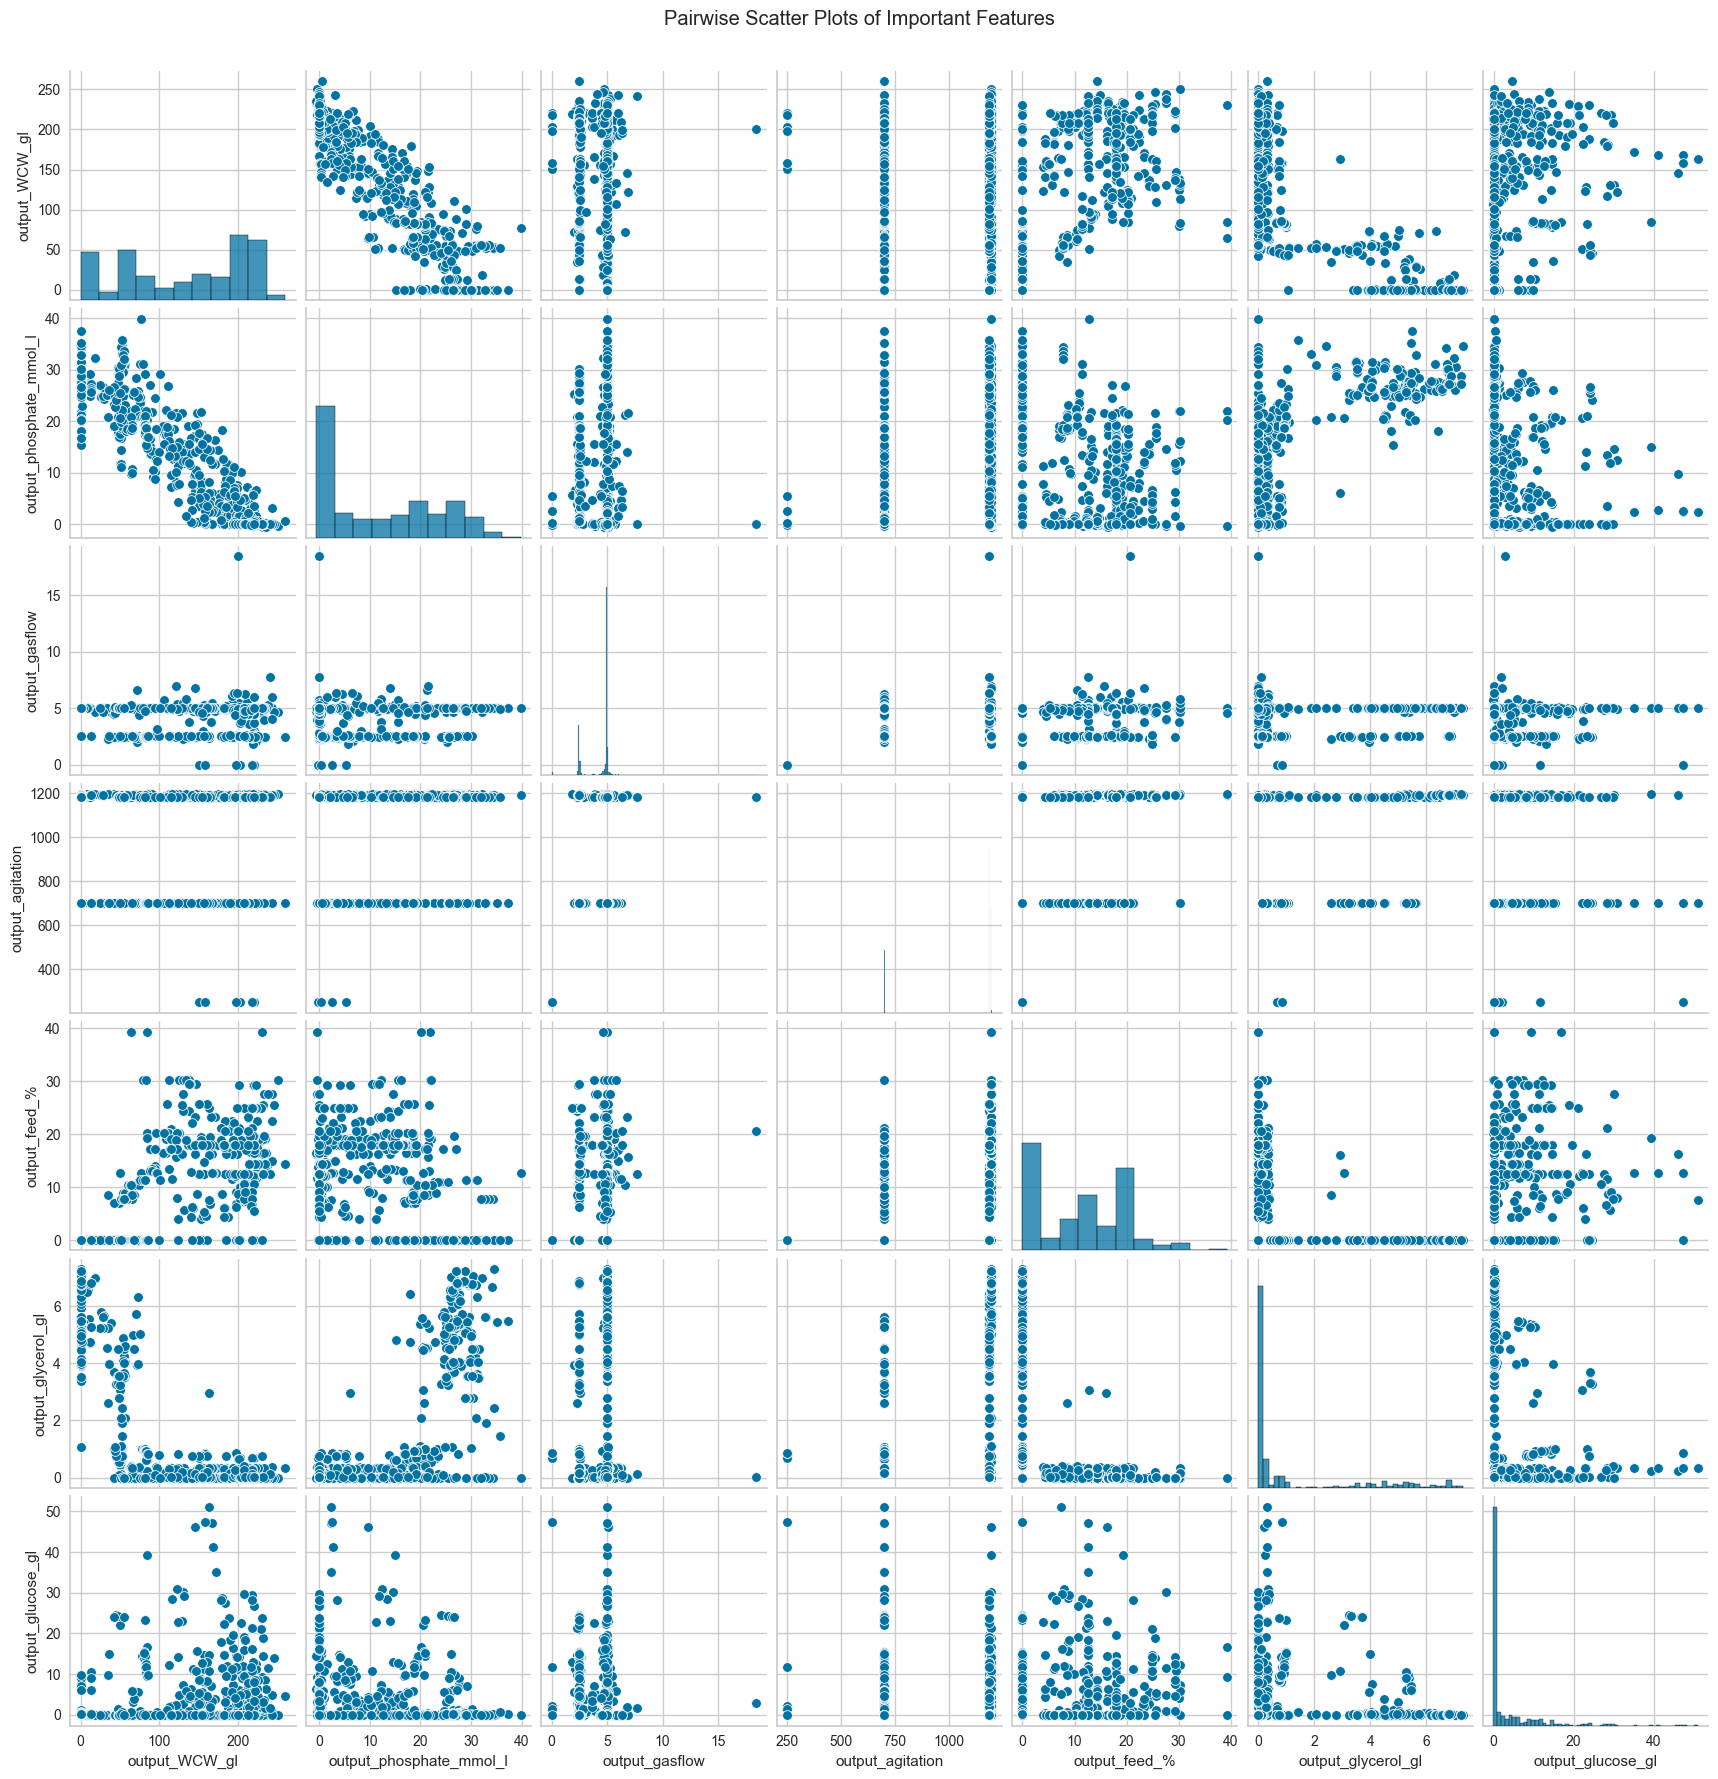

In [ ]:
sns.pairplot(important_features)
plt.suptitle('Pairwise Scatter Plots of Important Features', y=1.02)
plt.show()


> Adding Polynomial Features (Fix High Bias)

In [ ]:
# Adding Polynomial Features (to Fix High Bias) - do this only if there is high variance

from sklearn.preprocessing import PolynomialFeatures

def add_polynomial_features_sklearn(df, degree, columns=None, prefix='poly_'):
    """
    Adds polynomial features up to a specified degree to a subset of columns in a Pandas DataFrame using Scikit-Learn's PolynomialFeatures.
    
    Parameters:
        df (Pandas DataFrame): The DataFrame to which the polynomial features will be added.
        degree (int): The maximum degree of polynomial features to add.
        columns (list of str): The names of the columns to which polynomial features will be added. If None, all columns will be used.
        
    Returns:
        Pandas DataFrame: A new DataFrame with the original columns and polynomial features up to the specified degree.
    """
    
    # Select the columns to which polynomial features will be added
    if columns is None:
        columns = df.columns
    df_subset = df[columns]
    
    # Create a copy of the original DataFrame to avoid modifying it
    new_df = df.copy()
    
    # Create a PolynomialFeatures transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)    # interaction_only=False
    
    # Transform the subset of the DataFrame with polynomial features
    poly_df = poly.fit_transform(df_subset)
    
    # Create column names for the new DataFrame
    # col_names = [
    #     f"{col}^d{d}"
    #     for col in df_subset.columns
    #     for d in range(1, degree + 1)
    # ]
    col_names = [prefix + name for name in poly.get_feature_names_out(columns)]
    
    # Create a new DataFrame with the polynomial features
    poly_df = pd.DataFrame(poly_df, columns=col_names, index=df_subset.index)
    # poly_df = pd.DataFrame(poly_df, columns=poly.get_feature_names_out(important_features.columns), index=df_subset.index)
    
    # Merge the original DataFrame with the new DataFrame
    new_df = pd.concat([new_df, poly_df], axis=1)
    
    return new_df 




df_polynomial = add_polynomial_features_sklearn(df_combined_extra, degree = 2, columns=important_features.columns)



# data = [df_combined_extra, data_w_c123_extra, data_w0_c2_extra, data_agi_700_extra, data_agi_1200_extra, data_wo_glycerol_extra] 



    
# df_polynomial.reset_index(inplace=True, drop = True)
# df.drop(columns=['input_Timepoint (hr)'], inplace=True)


# print('Dataset Used: ', df_polynomial.name) # Print the name of the dataset being used for this iteration
s = setup(
    data=df_polynomial, 
    target='output_OD600', 
    # index_timeseries=date_index, 
    fold_strategy='timeseries', 
    session_id=123,  # Unique ID for reproducibility
    data_split_shuffle = False,
    fold_shuffle = False
)

# all_models = models()   #use this to visualize a table of models available in the model library.

# Compare models 
compare_results = compare_models(n_select=7, sort='MAE')    #the best 5 models will be highlighted

compare_results

# Evaluate each model
for model in compare_results:
    evaluate_model(model) 



,Description,Value
0,Session id,123
1,Target,output_OD600
2,Target type,Regression
3,Original data shape,"(684, 50)"
4,Transformed data shape,"(684, 50)"
5,Transformed train set shape,"(478, 50)"
6,Transformed test set shape,"(206, 50)"
7,Numeric features,49
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,8.9804,269.2718,14.1736,0.8773,0.2474,0.4044,0.1270
lightgbm,Light Gradient Boosting Machine,10.0102,328.9995,16.0757,0.8501,0.2948,0.4594,0.2050
xgboost,Extreme Gradient Boosting,10.0955,343.7830,16.4139,0.8383,0.2376,0.2388,0.2980
rf,Random Forest Regressor,10.4230,340.7772,16.5528,0.8386,0.2456,0.3123,0.2130
gbr,Gradient Boosting Regressor,10.4436,364.7963,16.6563,0.8311,0.2534,0.3154,0.1840
ada,AdaBoost Regressor,10.7735,349.2283,16.3128,0.8380,0.5012,1.3619,0.0830
huber,Huber Regressor,10.9893,322.3480,15.8079,0.8550,0.4450,1.0558,0.0580
knn,K Neighbors Regressor,11.2125,388.7417,16.9516,0.8092,0.3850,1.7614,0.1080
dt,Decision Tree Regressor,11.9689,491.8168,19.3098,0.7518,0.3469,0.3584,0.0350
br,Bayesian Ridge,12.4914,1918.8237,25.3179,0.1262,0.4324,1.1583,0.0520


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

> Automated Feature Engineering Tools 

In [ ]:
import featuretools as ft

# Assuming df is your raw DataFrame and you have a unique identifier column in it
es = ft.EntitySet(id='data')
es = es.entity_from_dataframe(entity_id='feature_data', dataframe=df, index='unique_id')

# Automatically generate new features
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='feature_data', max_depth=2)

# feature_matrix now contains new features


> Feature Extraction using Principal Component Analysis (PCA)

In [ ]:
# Standardize the features before applying PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(important_features)

# Apply PCA
pca = PCA(n_components=2)  # Change n_components based on your analysis
principal_components = pca.fit_transform(features_scaled)

# Convert to DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize the principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('Principal Component Analysis of Important Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Example: Create interaction features
for i in range(len(important_features.columns)):
    for j in range(i+1, len(important_features.columns)):
        col1, col2 = important_features.columns[i], important_features.columns[j]
        new_col_name = col1 + '_x_' + col2
        df[new_col_name] = df[col1] * df[col2]


> Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
reduced_features = pca.fit_transform(poly_features_df)


> Visualize Model Performance during Feature Selection/Extraction

In [ ]:
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="f1_weighted")

visualizer.fit(X, y)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

>> Feature Selection and Extraction - (Fix High Variance)

In [ ]:
# Addressing High Variance in Models through Feature Selection/Extraction

# Overview
    # Goal: Improve model generalization by reducing complexity or enhancing informative representations.
    # Application: Apply techniques to training data, then to test data.
    
# Initial Steps
    # Assess feature importance.
    # Options:
        # Add or remove features based on their importance.
        # Consider creating polynomial features for more complex relationships.

# Feature Selection/Extraction Strategies

    # Step 1: Manual Feature Adjustment
        # Add or remove features based on domain knowledge or preliminary analysis.
        
    # Step 2: Automated Techniques (start with feature selection)
    
        # Feature Selection Methods:
            # VarianceThreshold: Remove features with low variance.
            # Univariate Selection: Use methods like SelectKBest, SelectPercentile, or GenericUnivariateSelect.
            # Recursive Feature Elimination: RFE or RFECV (with cross-validation).
            # Model-Based Selection: Use SelectFromModel with L1-based (Lasso, Ridge, ElasticNet) or tree-based methods.
            # Sequential Feature Selector: Forward or backward selection (SFS).
            
        # Feature Extraction Methods:
            # Principal Component Analysis (PCA).
            # Independent Component Analysis (ICA).
            # t-Distributed Stochastic Neighbor Embedding (t-SNE).
        
        # Common Choices: PCA for extraction and SelectKBest for selection.

# Workflow for Model Improvement 
    # Build and test a model with normal data.
    # If accuracy is not satisfactory, perform feature selection and retest.
        # Optionally, add polynomial features to the selected features and retest.
    # If needed, proceed to feature extraction and retest.
        # Again, consider adding polynomial features and retesting.

> Adding Polynomial Features (Fix High Bias)

In [ ]:
# Adding Polynomial Features (to Fix High Bias) - do this only if there is high variance

from sklearn.preprocessing import PolynomialFeatures

df_polynomial = add_polynomial_features_sklearn(df, degree, columns=None)

>> Performing Regularization (fix High Variance)

In [ ]:
#Another way to fix High Bias or Variance is to perform regularization on the model.
#this would involve increasing or decreasing the regularization parameter (lambda) to fix high variance or bias


# By tuning the hyperparameters of the model using cross-validation, 
# we would have effectively applied regularization to the model, which can help to reduce overfitting and improve 
# its generalization performance.

#Hence the next step is MODEL OPTIMIZATION. 

<a id="6"></a> <br>
## Model Evaluation

> View Performance metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


def print_regression_performance_report(
    model, X_test, y_test, sarimax_model=True, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.
    Purpose: Print standard regression metrics report and generate visualizations.
    """

    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)
    if sarimax_model == True:
        y_pred = model.get_forecast(
            steps=len(X_test), exog=X_test
        ).predicted_mean.values
    else:
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error (MSE): {:.4f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
    print("R-squared (R2): {:.4f}".format(r2))
    # Add additional regression metrics and visualizations here
    # Plot actual vs predicted values
    plt.scatter(y_test, y_pred)
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

    return mse, rmse, r2, y_pred

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    model_fit, X_test, y_test, True, "set"
)  # SARIMAX model

NameError: name 'model_fit' is not defined

Mean Squared Error (MSE): 40.6236
Root Mean Squared Error (RMSE): 6.3737
R-squared (R2): 0.9644


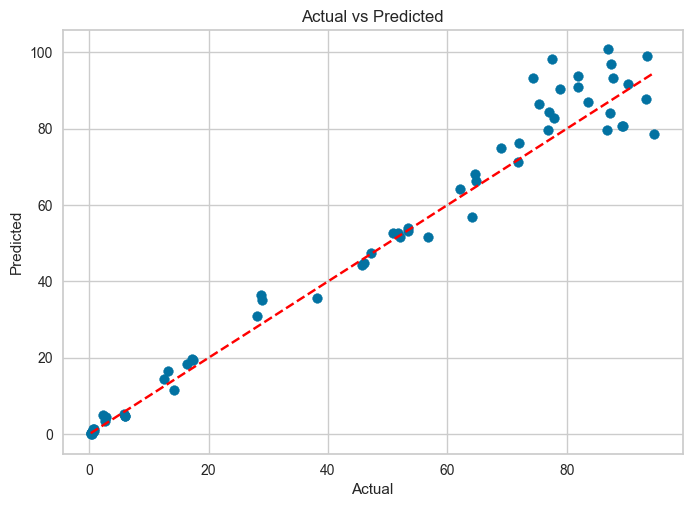

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    xgb_model_fit, X_test, y_test, False, "reset"
)

In [ ]:
# from yellowbrick.datasets import load_concrete
# from yellowbrick.regressor import ResidualsPlot


# visualizer = ResidualsPlot(model)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(estimator=xgb_model_fit, X=X_train, y=y_train, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, label='Training score')
# plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()


In [ ]:
from yellowbrick.regressor import ResidualsPlot
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


def residual_plot(model, X_train, y_train, X_test, y_test, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.

    Purpose: Print standard regression metrics report and generate visualizations.
    """
    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)

    visualizer = ResidualsPlot(xgb_model_fit, hist=False)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()  # Finalize and render the figure

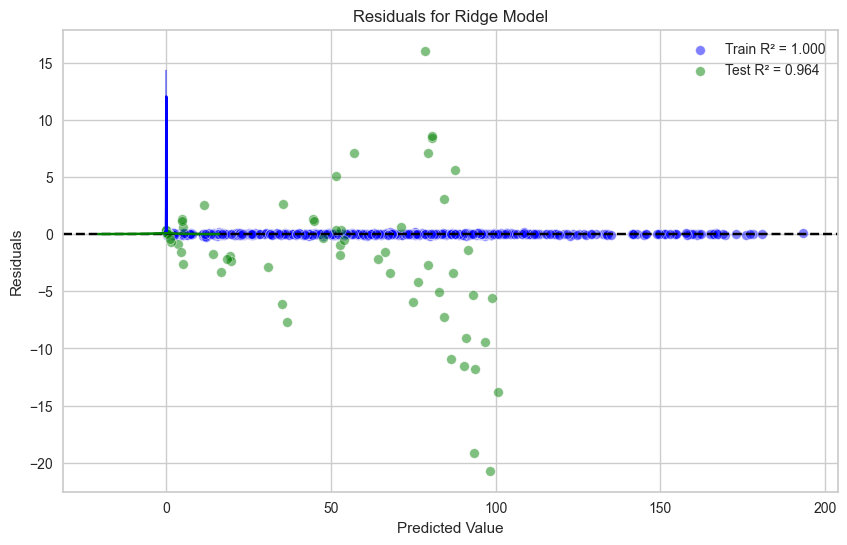

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


xgb_model_fit.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model_fit.predict(X_train)
y_test_pred = xgb_model_fit.predict(X_test)

# Compute the residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Calculate the R-squared values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create the residual plots
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plots for training and testing residuals
sns.scatterplot(
    x=y_train_pred,
    y=train_residuals,
    ax=ax,
    color="blue",
    alpha=0.5,
    label=f"Train R² = {train_r2:.3f}",
)
sns.scatterplot(
    x=y_test_pred,
    y=test_residuals,
    ax=ax,
    color="green",
    alpha=0.5,
    label=f"Test R² = {test_r2:.3f}",
)

# Plot a line at 0 for residuals
ax.axhline(y=0, color="black", linestyle="--")

# Annotations and labels
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.set_title("Residuals for Ridge Model")

# Plot histograms for residuals
sns.histplot(
    train_residuals,
    kde=True,
    color="blue",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)
sns.histplot(
    test_residuals,
    kde=True,
    color="green",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)

# Show legend and plot
ax.legend()
plt.show()

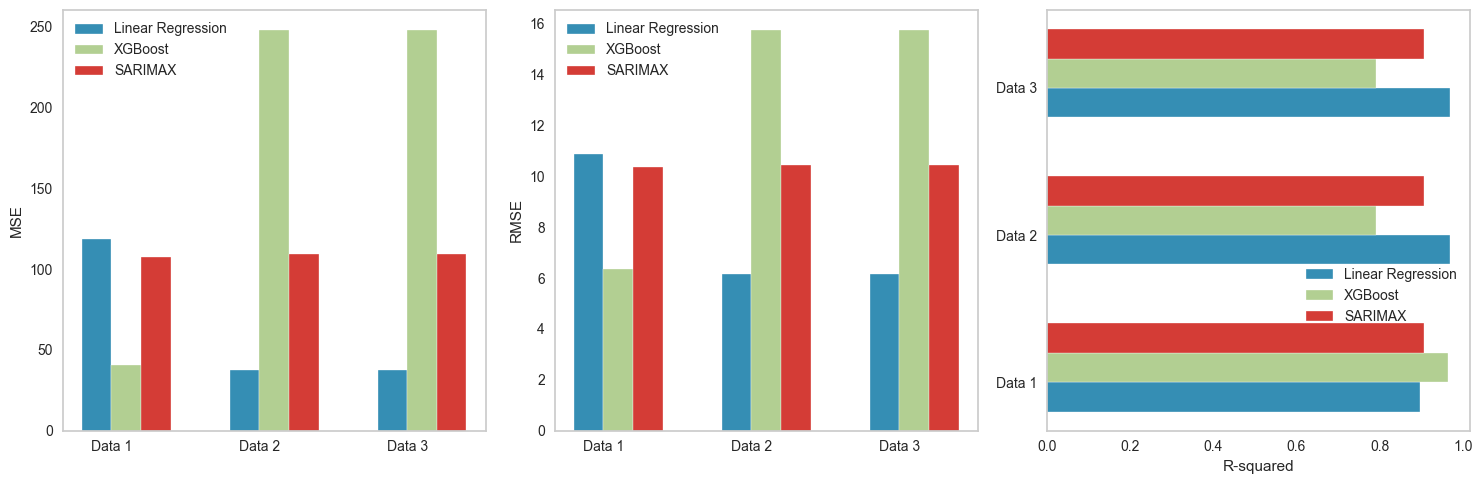

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and data
models = ["Linear Regression", "XGBoost", "SARIMAX"]

mse = [
    # Data 1
    [118.59194508422084, 40.62359283670584, 107.23563874099641],
    # Data 2
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
    # Data 3
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
]

rmse = [
    # Data 1
    [10.889992887243814, 6.373664004064368, 10.355464197272685],
    # Data 2
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
    # Data 3
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
]

r2 = [
    # Data 1
    [0.8962165146364349, 0.9644490353068284, 0.9061547701589259],
    # Data 2
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
    # Data 3
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
]


batches = ["Data 1", "Data 2", "Data 3"]

# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the positions of bars
index = np.arange(len(models))
bar_width = 0.2
opacity = 0.8

# Plotting MSE and RMSE as bar plots
for i, model in enumerate(models):
    mse_values = [mse[j][i] for j in range(len(batches))]
    rmse_values = [rmse[j][i] for j in range(len(batches))]

    axs[0].bar(index + i * bar_width, mse_values, bar_width, alpha=opacity, label=model)
    axs[1].bar(
        index + i * bar_width, rmse_values, bar_width, alpha=opacity, label=model
    )

# Plotting R2 as a horizontal bar plot
for i, model in enumerate(models):
    r2_values = [r2[j][i] for j in range(len(batches))]
    positions = index + i * bar_width  # Horizontal bar positions
    axs[2].barh(positions, r2_values, bar_width, alpha=opacity, label=model)

# Setting the labels and titles

# axs[0].set_title('MSE by Model')
# axs[1].set_title('RMSE by Model')
# axs[2].set_title('R2 by Model')
axs[0].set_xticks(index + bar_width / 2, batches)
axs[1].set_xticks(index + bar_width / 2, batches)
axs[2].set_yticks(index + bar_width / 2, batches)  # Adjust for horizontal bar plot
axs[0].set_ylabel("MSE")
axs[1].set_ylabel("RMSE")
axs[2].set_xlabel("R-squared")  # X-axis for horizontal bar plot
# axs[2].set_xlabel(r'$R^2$')  # X-axis for horizontal bar plot

# Adding legends
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
# Use bbox_to_anchor to move the legend slightly lower than the center right
axs[2].legend(loc="center right", bbox_to_anchor=(1, 0.32))

# remove grids
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

# Show plot
plt.tight_layout()
plt.show()

Mean Squared Error (MSE): 107.2356
Root Mean Squared Error (RMSE): 10.3555
R-squared (R2): 0.9062


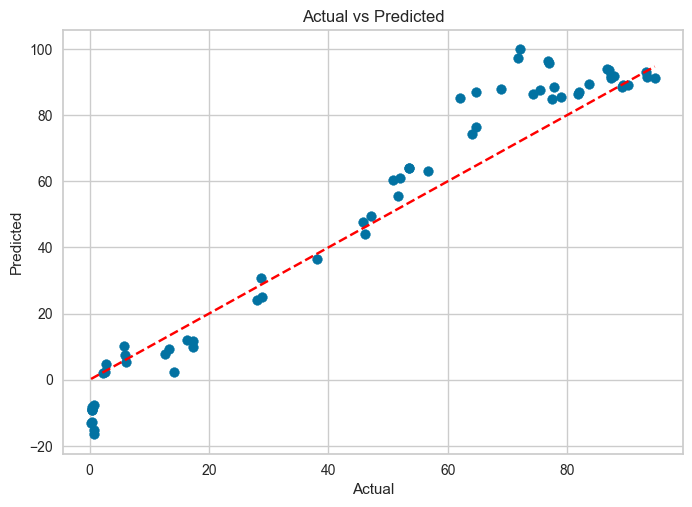

In [ ]:
#Regression performance report 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


mse, rmse, r2, y_pred = print_regression_performance_report(model_fit, X_test, y_test)

#Regression
    # Error = Actual value - Predicted value

    # MSE (Mean Square Error)
        # The square of the error over all samples is called Mean Squarred Error(MSE).
        # MSE = SQUARE(Actual value - Predicted value)/Number of Samples
    #RMSE (Root Mean Square Error)
    # MAE (Mean Absolute Error)
        # MAE = ABSOLUTE (Actual value - Predicted Value)


In [ ]:
import joblib

# Specify the filename for the saved model
model_filename = "sarimax_model.joblib"
joblib.dump(
    model_fit_2, f"models/{model_filename}"
)  # Save the trained SARIMAX model to file


# save the scaler
scaler_filename = "scaler.joblib"
joblib.dump(scaler, f"models/{scaler_filename}")  # Save the trained scaler to file


# Open a file in write-binary (wb) mode and save the model

print(f"Model saved to {model_filename}")

Model saved to sarimax_model.joblib


>> Learning Curve (Access the Bias and Variance) - Model Diagnostics

- `Bias` - error in the training data

- `Variance` -> difference in the errors between the train and test data. (i.e.,  it examines how the model's performance varies between the training data and unseen data (like a validation set).  If the model performs well on the training data but poorly on the validation/test data, it suggests high variance)


`High Bias (will also have High Variance) -> Underfitting:` The model is too simple and doesn't capture the complexities of the data well, leading to poor performance on both training and testing datasets.

`Low Bias + High Variance -> Overfitting:` The model is too complex, fitting too closely to the training data, including its noise and outliers. It performs well on training data but poorly on unseen data.

`Low Bias + Low Variance -> Ideal Model:` This is the desired outcome. The model accurately captures the underlying patterns in the data (low bias) and generalizes well to unseen data (low variance).

<p align="center">
  <img src="learning-curves.png" alt="Example Image"/>
</p>



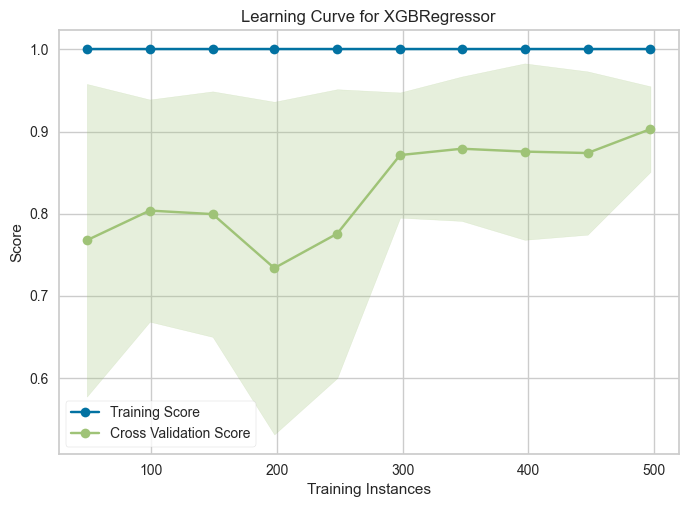

<Axes: title={'center': 'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:

#check Bias and Variance using Learnng Curve 


from yellowbrick.model_selection import LearningCurve

sizes = np.linspace(0.1, 1.0, 10) # Define the training set sizes to plot the learning curve

visualizer = LearningCurve(
    xgb_model_fit, cv=5, scoring='r2', train_sizes=sizes, n_jobs=4  #or use scoring = 'neg_mean_squared_error'
        )
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


# To fix high bias (underfitting):
    # get additional features or increasing the size of the model 
    # Adding polynomial features is a form of feature engineering that can increase the complexity of the model
    # decrease the regularization parameter (lambda) to allow the model's learning algorithm to fit the data more flexibly, 
        # thereby potentially reducing bias

# To fix high variance (overfitting):
    # Obtaining more training samples can help the model generalize better.
    # Simplifying the model by reducing the number of features (feature selection) can prevent the model from fitting noise in the 
        # training data.
    # Increasing the regularization parameter (lambda) adds a penalty to the model complexity, which can help in preventing overfitting.


> Cross Validation Scores

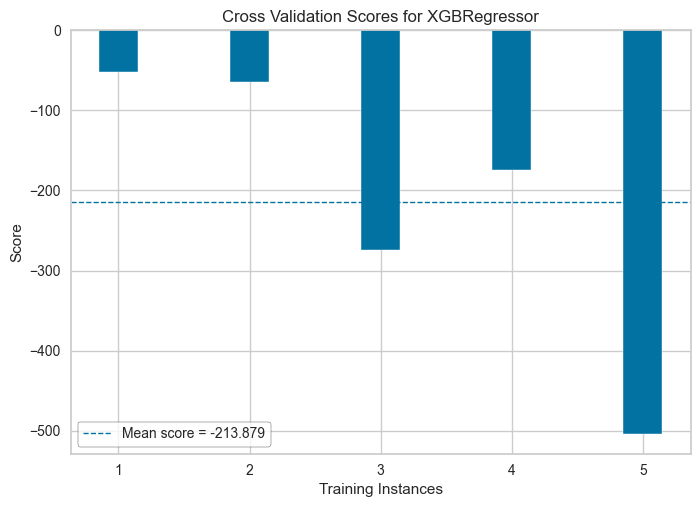

<Axes: title={'center': 'Cross Validation Scores for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
from sklearn.model_selection import (
    learning_curve,
    cross_val_score,
    KFold,
    train_test_split,
)
from yellowbrick.model_selection import (
    CVScores,
)  # visualizing the cross validation scores

# check Bias and Variance using Cross Validation

cv = 5  # or # Create a cross-validation object:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

visualizer = CVScores(xgb_model_fit, cv=cv, scoring="neg_mean_squared_error")

visualizer.fit(X_train, y_train)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

> Plot Validation Curves (to analyse the impact of each Hyperparameter)

In [ ]:
# to analyze the impact of varying hyperparameter values on the model's performance using Validation curve
# the validation curve is useful for hyperparameter tuning, while the learning curve is used to assess bias and variance.

# Using validation curves is a fundamental aspect of machine learning model tuning, as it provides valuable insights into how
# hyperparameters influence model performance, aiding in the selection of the most appropriate model settings.

from sklearn.model_selection import validation_curve


# the hyperparameter used here is 'max_depth'. A hyperparameter for the model ExtraTreeRegressor

plot_validation_curve(
    model, X_train, y_train, param_name="max_depth", cv=5, scoring="r2"
)

In [ ]:
from yellowbrick.model_selection import ValidationCurve

# cv = StratifiedKFold(4)
viz = ValidationCurve(
    xgb_model_fit,
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    scoring="r2",
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

>> Analyze Error Distribution

In [ ]:
# if the errors are normally distributed around zero, it may indicate that the model is making unbiased predictions. 
# If there is a pattern or trend in the errors, it may suggest that the model has systematic biases or is making 
# consistent errors in certain regions of the input space


analyze_error_distribution(y_val, y_pred)

>> Error Analysis - Diagnostics

In [ ]:
#Error analysis is the process of analyzing the errors made by a machine learning model and identifying the patterns 
# or trends that may be causing the errors. The goal of error analysis is to gain insight into the behavior of the 
# model and identify areas for improvement. 

# The steps involved in error analysis:
    # 1. Collect error data - Gather instances where the model made incorrect predictions.
    # 2. Categorize errors - Classify errors into meaningful categories.
    # 3. Identify patterns - Look for commonalities or trends among the errors.
    # 4. Analyze causes - Investigate potential reasons behind these patterns.
    # 5. Prioritize fixes - Decide which errors to address first based on their impact.

    
# Based on the insights gained from the error analysis, you can perform the following.

# False negatives: 
    # To fix this issue, you may consider the following:
        # Increase the weight of the features that are more indicative of churn for low-usage customers, 
            # such as frequency of usage or specific product usage. (adjust the model parameters)
        # Add new features that may be predictive of churn, such as customer sentiment or customer service interactions.
        # Use a different model architecture that is better suited for handling imbalanced data, such as a decision tree 
            # or ensemble model. 


# False positives:
    # To fix this issue, you may consider the following:
        # Decrease the weight of features that are causing false positives, such as age or income, if they are not as 
            # indicative of churn for low-usage customers. (adjust the model parameters)
        # Remove features that are causing false positives altogether, if they are not providing significant value to the 
            # model.
        # Increase the size of the training dataset to capture a more representative sample of customers who do not churn, 
            # which may help the model learn more accurately which customers are likely to churn.


<a id="8"></a> <br>
## Model Optimization

>> Auto Hyperparameter Optimization using Optuna

In [ ]:
from sklearn.svm import SVC
import optuna

SVC().get_params()

In [ ]:
# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING)


def objective(trial):
    # Define the hyperparameters' search space
    C = trial.suggest_loguniform("C", 1e-4, 1e4)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    degree = (
        trial.suggest_int("degree", 1, 5) if kernel == "poly" else 3
    )  # degree is only used for 'poly' kernel

    # Create the SVM model
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=True)

    cv = StratifiedKFold(n_splits=10, random_state=11, shuffle=True)

    # Perform cross-validation and compute the average AUC score
    scores = cross_val_score(
        model, train_data, train_labels, scoring="roc_auc", n_jobs=-1, cv=cv
    )
    avg_auc_test = np.mean(scores)

    return avg_auc_test


# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_hyperparams = study.best_trial.params
# print('Best Hyperparameters:', best_hyperparams)

In [ ]:
# Best hyperparameters obtained from Optuna
best_C_svm = best_hyperparams["C"]
best_kernel = best_hyperparams["kernel"]
best_gamma = best_hyperparams["gamma"]
best_degree = best_hyperparams["degree"]


print("Best C (svm): {}".format(best_C_svm))
print("Best kernel: {}".format(best_kernel))
print("Best gamma: {}".format(best_gamma))
print("Best degree: {}".format(best_degree))

tuned_svm_model = SVC(
    C=best_C_svm,
    kernel=best_kernel,
    gamma=best_gamma,
    degree=best_degree,
    probability=True,
)

tuned_svm_model.fit(train_data, train_labels)

dump(tuned_svm_model, "models/tuned_model/tuned_support_vector.joblib")

In [ ]:
y_pred, ACC, PC, RC, FS, AP, roc_auc, gini = (
    print_classification_performance2class_report(
        tuned_svm_model, valid_data, valid_labels
    )
)